In [1]:
import os
from pathlib import Path
from shapely.geometry import Polygon
import matplotlib
import matplotlib.pyplot as plt
import flopy
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import geopandas as gpd
import numpy as np
from IPython.display import display
import shutil

In [2]:
cwd = os.getcwd()
truth_model_dir = Path('../../Refined_Truth_Model/Modflow_Input_Files').resolve()
base_model_dir = Path('../../Base_Model_for_Scenarios').resolve()
print(cwd)
print(truth_model_dir)
print(base_model_dir)

C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures
C:\Users\farnut1\Desktop\How-Many-Realizations-main\Refined_Truth_Model\Modflow_Input_Files
C:\Users\farnut1\Desktop\How-Many-Realizations-main\Base_Model_for_Scenarios


In [3]:
# Get grid geodataframe from truth model
# Load model
truthsim = flopy.mf6.MFSimulation.load('fp_mf6_model', sim_ws=truth_model_dir, exe_name='mf6.exe')
truthmodel = truthsim.get_model('fp_mf6_model')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package riv...
    loading package ghb...
    loading package wel...
    loading package rch...
    loading package npf...
    loading package oc...
  loading model prt6...
    loading package dis...
    loading package mip...
    loading package prp...
    loading package oc...
  loading exchange package gwf-prt_exg_0...
  loading solution package fp_mf6_model...
  loading solution package mf6_prt...


In [4]:
# Get geodataframe and nodes of truth model for use later
modelprops = truthmodel.modelgrid.geo_dataframe.reset_index()
modelprops = modelprops.rename(columns={'index':'node'})
# Make 1 based
modelprops['node'] +=1

# Get lay, row, col in a list for every cell
lrc_list = []
for i in range (int(truthmodel.modelgrid.nnodes/truthmodel.modelgrid.nlay)):
    lrc_list+=truthmodel.modelgrid.get_lrc(i)

# convert to a dataframe with headings of lay, row, col
modelprops_df = pd.DataFrame(lrc_list, columns =['lay', 'row','column'])

# drop lay column
modelprops_df = modelprops_df.drop('lay', axis=1)

# Make node column
modelprops_df = modelprops_df.reset_index().rename(columns={"index":"node"})

# Add 1 to each to get to 1 based
modelprops_df+=1
        
# Add idomain's to dataframe
dataset = list(truthmodel.dis.idomain.data[0].flat)
modelprops_df['idomain_1']=dataset  

# Add recharge to dataframe
dataset = list(truthmodel.rcha_0.recharge.data.flat)
modelprops_df['rch']=dataset

# Add k's to dataframe
dataset = list(truthmodel.npf.k.data[0].flat)
modelprops_df['k_1']=dataset
        
# Merge with modelprops to get geometry column
modelprops_df = modelprops_df.merge(modelprops, on='node')
# Convert to geodataframe
truth_modelprops_df = gpd.GeoDataFrame(modelprops_df, crs='EPSG:26915', geometry='geometry')

# drop columns
truth_modelprops_df = truth_modelprops_df[['rch','k_1','geometry']].copy()

In [5]:
# Get grid geodataframe from base model
# Load model
basesim = flopy.mf6.MFSimulation.load('fp_mf6_model', sim_ws=base_model_dir, exe_name='mf6.exe')
basemodel = basesim.get_model('fp_mf6_model')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package riv...
    loading package ghb...
    loading package wel...
    loading package rch...
    loading package npf...
    loading package oc...
  loading solution package fp_mf6_model...


In [6]:
# Get geodataframe and nodes of truth model for use later
modelprops = basemodel.modelgrid.geo_dataframe.reset_index()
modelprops = modelprops.rename(columns={'index':'node'})
# Make 1 based
modelprops['node'] +=1

# Get lay, row, col in a list for every cell
lrc_list = []
for i in range (int(basemodel.modelgrid.nnodes/basemodel.modelgrid.nlay)):
    lrc_list+=basemodel.modelgrid.get_lrc(i)

# convert to a dataframe with headings of lay, row, col
modelprops_df = pd.DataFrame(lrc_list, columns =['lay', 'row','column'])

# drop lay column
modelprops_df = modelprops_df.drop('lay', axis=1)

# Make node column
modelprops_df = modelprops_df.reset_index().rename(columns={"index":"node"})

# Add 1 to each to get to 1 based
modelprops_df+=1
        
# Add idomain's to dataframe
dataset = list(basemodel.dis.idomain.data[0].flat)
modelprops_df['idomain_1']=dataset  
        
# Merge with modelprops to get geometry column
modelprops_df = modelprops_df.merge(modelprops, on='node')
# Convert to geodataframe
base_modelprops_df = gpd.GeoDataFrame(modelprops_df, crs='EPSG:26915', geometry='geometry')

In [7]:
# Convert Truth Model rch and K to coarser base model grid
truth_model_k_rch_basegrid = gpd.sjoin(base_modelprops_df, truth_modelprops_df, how='left', predicate='intersects')

# keep only first of duplicate rows
truth_model_k_rch_basegrid = truth_model_k_rch_basegrid.drop_duplicates(subset=['node'], keep='first')
truth_model_k_rch_basegrid.reset_index(drop=True, inplace=True)
truth_model_k_rch_basegrid

,node,row,column,idomain_1,geometry,index_right,rch,k_1
0,1,1,1,1,"POLYGON ((0 10000, 0 9975, 25 9975, 25 10000, ...",3202,0.000131,10.37000
1,2,1,2,1,"POLYGON ((25 10000, 25 9975, 50 9975, 50 10000...",3203,0.000131,10.37000
2,3,1,3,1,"POLYGON ((50 10000, 50 9975, 75 9975, 75 10000...",3211,0.000131,10.37000
3,4,1,4,1,"POLYGON ((75 10000, 75 9975, 100 9975, 100 100...",3216,0.000131,10.37550
4,5,1,5,1,"POLYGON ((100 10000, 100 9975, 125 9975, 125 1...",3216,0.000131,10.37550
...,...,...,...,...,...,...,...,...
79995,79996,400,196,0,"POLYGON ((4875 25, 4875 0, 4900 0, 4900 25, 48...",1279983,0.000145,4.31850
79996,79997,400,197,0,"POLYGON ((4900 25, 4900 0, 4925 0, 4925 25, 49...",1279987,0.000145,4.31926
79997,79998,400,198,0,"POLYGON ((4925 25, 4925 0, 4950 0, 4950 25, 49...",1279991,0.000145,4.32008
79998,79999,400,199,0,"POLYGON ((4950 25, 4950 0, 4975 0, 4975 25, 49...",1279991,0.000145,4.32008


In [8]:
# Export Grid outline
gridoutline_list = [[basemodel.modelgrid.extent[0], basemodel.modelgrid.extent[2]],[basemodel.modelgrid.extent[0], basemodel.modelgrid.extent[3]],[basemodel.modelgrid.extent[1], basemodel.modelgrid.extent[3]],[basemodel.modelgrid.extent[1], basemodel.modelgrid.extent[2]]]
gridoutline_geom = Polygon(gridoutline_list)
gridoutline_gpd = gpd.GeoDataFrame(index=[0], crs=basemodel.modelgrid.crs, geometry=[gridoutline_geom])
#gridoutline_gpd.to_file(os.path.join(cwd,"BaseModel_GridOutline.shp"))

In [9]:
# export no flow cells
basegrid_noflow = truth_model_k_rch_basegrid[truth_model_k_rch_basegrid['idomain_1']<1]
basegrid_noflow = basegrid_noflow.dissolve(by='idomain_1')
#basegrid_noflow.to_file(os.path.join(cwd,'noflowcells.shp'))

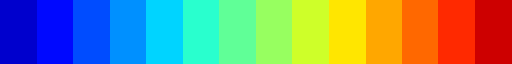

In [10]:
# 15 jet
levels_legend = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
cmap = matplotlib.cm.jet
clrs_legend = []
for step in np.linspace(0,1,16):
    clrs_legend.append(matplotlib.colors.rgb2hex(cmap(step)))

cmap_legend, norm_legend = matplotlib.colors.from_levels_and_colors(levels_legend, clrs_legend, extend='both')
cmap_legend

In [11]:
# Get list of all folders in scenario_notebook folder
folders = [f.name for f in os.scandir(cwd) if f.is_dir()]

# Filter to just our possible scenarios
group_folders = []
for file in folders:
    if file.startswith('Group'):
        group_folders.append(file)
print(group_folders)

['Group_1', 'Group_10', 'Group_11', 'Group_12', 'Group_2', 'Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7', 'Group_8', 'Group_9']


In [15]:
for groups in group_folders:
    listdir = os.listdir(groups)

    for iteration in range(0,5,1):   
        # Get all shps in directory per iteration
        iter_shps = []
        for file in listdir:
            if file.endswith(f'_{iteration}.shp'):
                iter_shps.append(file)
                
        if iter_shps[0].startswith('R25_pp10'):
            obs = 'Obs: Random 25'
            pp = 'PP: 800'
            filesave = 'R25_pp10'
        if iter_shps[0].startswith('R100_pp10'):
            obs = 'Obs: Random 100'
            pp = 'PP: 800'
            filesave = 'R100_pp10'
        if iter_shps[0].startswith('C25_pp10'):
            obs = 'Obs: Clustered 25'
            pp = 'PP: 800'
            filesave = 'C25_pp10'
        if iter_shps[0].startswith('C100_pp10'):
            obs = 'Obs: Clustered 100'
            pp = 'PP: 800'
            filesave = 'C100_pp10'
        if iter_shps[0].startswith('R25_pp25'):
            obs = 'Obs: Random 25'
            pp = 'PP: 128'
            filesave = 'R25_pp25'
        if iter_shps[0].startswith('R100_pp25'):
            obs = 'Obs: Random 100'
            pp = 'PP: 128'
            filesave = 'R100_pp25'
        if iter_shps[0].startswith('C25_pp25'):
            obs = 'Obs: Clustered 25'
            pp = 'PP: 128'
            filesave = 'C25_pp25'
        if iter_shps[0].startswith('C100_pp25'):
            obs = 'Obs: Clustered 100'
            pp = 'PP: 128'
            filesave = 'C100_pp25'
        if iter_shps[0].startswith('R25_pp50'):
            obs = 'Obs: Random 25'
            pp = 'PP: 32'
            filesave = 'R25_pp50'
        if iter_shps[0].startswith('R100_pp50'):
            obs = 'Obs: Random 100'
            pp = 'PP: 32'
            filesave = 'R100_pp50'
        if iter_shps[0].startswith('C25_pp50'):
            obs = 'Obs: Clustered 25'
            pp = 'PP: 32'
            filesave = 'C25_pp50'
        if iter_shps[0].startswith('C100_pp50'):
            obs = 'Obs: Clustered 100'
            pp = 'PP: 32'
            filesave = 'C100_pp50'
        
        for i in iter_shps:
            if '_real10_' in i:
                real10 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real25_' in i:
                real25 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real50_' in i:
                real50 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real100_' in i:
                real100 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real250_' in i:
                real250 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real500_' in i:
                real500 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real1000_' in i:
                real1000 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')
            if '_real2000_' in i:
                real2000 = gpd.read_file(os.path.join(cwd,groups,i),engine='pyogrio')

        # Make figure
        fig = plt.figure(figsize=(15,10))
        plt.rcParams['font.family'] = 'Calibri'
        ax1 = plt.subplot2grid((10,15), (2,0), rowspan=5, colspan=3) # (subplot grid, num rows, num cols), (start row, start col)
        ax2 = plt.subplot2grid((10,15), (0,3), rowspan=5, colspan=3)
        ax3 = plt.subplot2grid((10,15), (0,6), rowspan=5, colspan=3)
        ax4 = plt.subplot2grid((10,15), (0,9), rowspan=5, colspan=3)
        ax5 = plt.subplot2grid((10,15), (0,12), rowspan=5, colspan=3)
        ax6 = plt.subplot2grid((10,15), (5,0), rowspan=5, colspan=3)
        ax7 = plt.subplot2grid((10,15), (5,3), rowspan=5, colspan=3)
        ax8 = plt.subplot2grid((10,15), (5,6), rowspan=5, colspan=3)
        ax9 = plt.subplot2grid((10,15), (5,9), rowspan=5, colspan=3)
        ax10 = plt.subplot2grid((10,15), (5,12), rowspan=5, colspan=3)
        
        # ax1 (true)
        ax1.axis('off')
        ax1.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax1.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax1, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax1, color='black', zorder=10)
        truth_model_k_rch_basegrid.plot(ax=ax1, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.19, 0.33, 'True K', fontsize=12)
        
        # ax2 (real10)
        ax2.axis('off')
        ax2.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax2.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax2, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax2, color='black', zorder=10)
        real10.plot(ax=ax2, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.32, 0.89, 'Realizations: 10', fontsize=12)
        
        # ax3 (real25)
        ax3.axis('off')
        ax3.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax3.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax3, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax3, color='black', zorder=10)
        real25.plot(ax=ax3, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.48, 0.89, 'Realizations: 25', fontsize=12)
        
        # ax4 (real50)
        ax4.axis('off')
        ax4.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax4.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax4, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax4, color='black', zorder=10)
        real50.plot(ax=ax4, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.63, 0.89, 'Realizations: 50', fontsize=12)
        
        # ax5 (real100)
        ax5.axis('off')
        ax5.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax5.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax5, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax5, color='black', zorder=10)
        real100.plot(ax=ax5, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.79, 0.89, 'Realizations: 100', fontsize=12)
        
        # ax7 (real250)
        ax7.axis('off')
        ax7.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax7.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax7, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax7, color='black', zorder=10)
        real250.plot(ax=ax7, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.32, 0.09, 'Realizations:250', fontsize=12)
        
        # ax8 (real500)
        ax8.axis('off')
        ax8.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax8.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax8, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax8, color='black', zorder=10)
        real500.plot(ax=ax8, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.48, 0.09, 'Realizations: 500', fontsize=12)
        
        # ax9 (real1000)
        ax9.axis('off')
        ax9.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax9.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax9, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax9, color='black', zorder=10)
        real1000.plot(ax=ax9, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.63, 0.09, 'Realizations: 1000', fontsize=12)
        
        # ax10 (real2000)
        ax10.axis('off')
        ax10.set_xlim([gridoutline_gpd.bounds.minx[0]-10, gridoutline_gpd.bounds.maxx[0]+10])
        ax10.set_ylim([gridoutline_gpd.bounds.miny[0]-10, gridoutline_gpd.bounds.maxy[0]+10])
        gridoutline_gpd.plot(ax=ax10, color='none', edgecolor='black', linewidth=1, zorder=9)
        basegrid_noflow.plot(ax=ax10, color='black', zorder=10)
        real2000.plot(ax=ax10, column='k_1', cmap='jet', vmin=1, vmax=15)
        plt.gcf().text(0.79, 0.09, 'Realizations: 2000', fontsize=12)
        
        # ax6 (legend)
        ax6.axis('off')
        legend_colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm_legend, cmap=cmap_legend), ax=ax6, orientation='horizontal', ticks=[1,5,10,15])
        legend_colorbar.ax.tick_params(labelfontfamily='calibri', labelsize=10)
        legend_colorbar.ax.set_title('Hydraulic Conductivity (m/d)', family='calibri', fontsize=10)
        ax6.text(0.01,2.5, 'Base Realization', family='calibri', fontsize=16, weight='bold', transform=ax6.transAxes)
        if iteration == 0:
            ax6.text(0.01,2.4, f'Prior', family='calibri', fontsize=16, weight='bold', transform=ax6.transAxes)
        if iteration !=0:
            ax6.text(0.01,2.4, f'Posterior: {iteration}', family='calibri', fontsize=16, weight='bold', transform=ax6.transAxes)
        ax6.text(0.01,2.3, f'{obs}', family='calibri', fontsize=16, weight='bold', transform=ax6.transAxes)
        ax6.text(0.01,2.2, f'{pp}', family='calibri', fontsize=16, weight='bold', transform=ax6.transAxes)
        
        fig.savefig(os.path.join(cwd, groups, f'kfields_iter{iteration}_{filesave}.png'), bbox_inches='tight', dpi=300)
        print('saved', os.path.join(cwd, groups, f'kfields_iter{iteration}_{filesave}.png'))
        plt.close()

saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_1\kfields_iter0_R25_pp10.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_1\kfields_iter1_R25_pp10.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_1\kfields_iter2_R25_pp10.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_1\kfields_iter3_R25_pp10.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_1\kfields_iter4_R25_pp10.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_10\kfields_iter0_R100_pp50.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_10\kfields_iter1_R100_pp50.png
saved C:\Users\farnut1\Desktop\How-Many-Realizations-main\Scenario_Notebook\Charts_Figures\Group_10\kfields_iter2_